In [134]:
### WILL BE NEEDED LATER

## Split data into training and test sets
# train_data, test_data = train_test_split(data, test_size = 0.2, random_state = 42)
# X_train = train_data[independent_vars]
# y_train = train_data[dependent_var]

## Evaluate the model
# X_test = test_data[independent_vars]
# y_test = test_data[dependent_var]
# X_test = sm.add_constant(X_test)
# y_pred = model.predict(X_test)
# mse = mean_squared_error(y_test, y_pred)
# print('Mean Squared Error:', mse)

## Check multicollinearity using VIF
# vif_data = pd.DataFrame()
# vif_data['feature'] = X_train.columns
# vif_data['VIF'] = [variance_inflation_factor(X_train.values, i) for i in range(X_train.shape[1])]
# print(vif_data)

In [135]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn.model_selection import LeaveOneOut, train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import f

In [136]:
# Step 1: Data Preparation
# Load dataset
data = pd.read_csv('biele_WM_new.csv')

In [137]:
# Select relevant variables and update original dataset to data
columns = ["mietekalt", "qm_Preis", "wohnflaeche", "alter", "objektzustand", "zimmeranzahl", 
           "balkon", "einbaukueche", "keller", "ausstattung_kat", "aufzug", "gaestewc", 
           "garten", "heizungsart", "barrierefrei", "Einstellungsmonat"]
data = data[columns]

In [138]:
# Rename variables for clarity
data.rename(columns = {'mietekalt': 'netrent', 
                     'qm_Preis': 'rent_per_sqm', 
                     'wohnflaeche': 'area', 
                     'alter': 'age', 
                     'objektzustand': 'condition_cat', 
                     'zimmeranzahl': 'rooms', 
                     'balkon': 'balcony', 
                     'einbaukueche': 'kitchen', 
                     'keller': 'basement', 
                     'ausstattung_kat': 'appointments_cat', 
                     'aufzug': 'lift', 
                     'gaestewc': 'guesttoilet', 
                     'garten': 'garden', 
                     'heizungsart': 'heating_cat', 
                     'barrierefrei': 'barrierfree', 
                     'Einstellungsmonat': 'month'}, inplace= True)

In [139]:
# Drop rows with missing values
data = data.dropna()

In [140]:
# Encode categorical variables
data = pd.get_dummies(data,
                      columns = ['condition_cat', 'appointments_cat', 'heating_cat', 'month'],
                      drop_first = True, dtype = int)

In [141]:
# Define dependent and independent variables
dependent_var = 'netrent'
independent_vars = [col for col in data.columns if col not in [dependent_var, 'rent_per_sqm']]

# MODEL WITH statsmodels

In [142]:
# Fit the linear regression model
X = data[independent_vars]
y = data[dependent_var]
X = sm.add_constant(X)
model = sm.OLS(y, X).fit()

In [143]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                netrent   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     251.6
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:05:38   Log-Likelihood:                -14348.
No. Observations:                2371   AIC:                         2.878e+04
Df Residuals:                    2329   BIC:                         2.902e+04
Df Model:                          41                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 75.2509     35

# MODEL BY HAND

In [144]:
# Extract values of dependent and independent variables
X_val = data[independent_vars].values
y_val = data[dependent_var].values

In [145]:
# Add intercept
intercept = np.ones((X_val.shape[0], 1))             # Create a column of ones
X_with_intercept = np.hstack((intercept, X_val))     # Combine intercept with X

In [146]:
# X_1: Design matrix (including intercept column)
# y_1: Dependent variable (netrent)
X_1 = np.array(X_with_intercept)
y_1 = np.array(y_val)

# Estimate beta_hat
beta_hat_1 = np.linalg.inv(X_1.T @ X_1) @ X_1.T @ y_1

# Compute the hat matrix (H)
H_1 = X_1 @ np.linalg.inv(X_1.T @ X_1) @ X_1.T

# Residuals (epsilon_hat)
epsilon_hat_1 = (np.eye(len(y_1)) - H_1) @ y_1

# Fitted values (y_hat)
y_hat_1 = H_1 @ y_1

# Estimate sigma^2 (residual variance)
n, k = X_1.shape
sigma2_hat_1 = (1 / (n - k)) * (epsilon_hat_1.T @ epsilon_hat_1)

# Covariance matrix of beta_hat
Cov_beta_hat_1 = sigma2_hat_1 * np.linalg.inv(X_1.T @ X_1)

# Standard errors of beta_hat
sd_beta_hat_1 = np.sqrt(np.diag(Cov_beta_hat_1))

In [147]:
# Print results
print("Beta_hat:", beta_hat_1)
print("Residual variance (sigma^2):", sigma2_hat_1)
print("Covariance matrix of beta_hat:\n", Cov_beta_hat_1)
print("Standard errors of beta_hat:", sd_beta_hat_1)

Beta_hat: [  75.25091185    7.88453808    0.26249254  -19.90707751    4.38460198
   38.56353188  -15.60593987   23.57805351   25.97218506   -4.39188488
   -1.71481204 -113.79585981  -64.04700799 -127.90789323 -161.14658736
 -146.03716572 -162.51433542 -191.78494811   -8.86677729   56.63517935
  104.96639      63.3989163    92.71166209  101.34916105   57.5555872
  123.17281881  -33.67983097   36.68584327  189.95266835   49.98840114
   47.67830633   19.46468709   13.21214688   14.95891497   20.95401931
   12.04620183   29.3112045     8.89419341   19.27984687   16.61950765
   19.34322877   20.39047849]
Residual variance (sigma^2): 10749.293659726918
Covariance matrix of beta_hat:
 [[ 1.23499250e+03 -1.30393435e-01 -1.94662325e-01 ... -6.60174233e+01
  -5.17800461e+01 -4.67114887e+01]
 [-1.30393435e-01  2.65337780e-02 -2.90465443e-04 ... -1.77223749e-02
  -3.84351055e-02 -3.50265978e-02]
 [-1.94662325e-01 -2.90465443e-04  6.83664146e-03 ... -2.91085804e-02
   5.19167092e-03 -2.16668834e-02

In [148]:
# Comparison of coefficients and standard deviations
coeff_comparison = np.vstack([model.params, beta_hat_1])
stddev_comparison = np.vstack([model.bse, sd_beta_hat_1])

In [149]:
# Display results
print("Comparison of Coefficients:")
print(pd.DataFrame(coeff_comparison, index=["Statsmodels", "By-Hand"], 
                   columns=['intercept'] + independent_vars))
print("\nComparison of Standard Deviations:")
print(pd.DataFrame(stddev_comparison, index=["Statsmodels", "By-Hand"], 
                   columns=['intercept'] + independent_vars))

Comparison of Coefficients:
             intercept      area       age      rooms   balcony    kitchen  \
Statsmodels  75.250912  7.884538  0.262493 -19.907078  4.384602  38.563532   
By-Hand      75.250912  7.884538  0.262493 -19.907078  4.384602  38.563532   

             basement       lift  guesttoilet    garden  ...    month_3  \
Statsmodels -15.60594  23.578054    25.972185 -4.391885  ...  13.212147   
By-Hand     -15.60594  23.578054    25.972185 -4.391885  ...  13.212147   

               month_4    month_5    month_6    month_7   month_8    month_9  \
Statsmodels  14.958915  20.954019  12.046202  29.311204  8.894193  19.279847   
By-Hand      14.958915  20.954019  12.046202  29.311204  8.894193  19.279847   

              month_10   month_11   month_12  
Statsmodels  16.619508  19.343229  20.390478  
By-Hand      16.619508  19.343229  20.390478  

[2 rows x 42 columns]

Comparison of Standard Deviations:
             intercept      area       age     rooms   balcony   kitch

# HYPOTHESIS TESTING

In [150]:
# List of variables to exclude
exclude_vars = ['balcony', 'garden', 'barrierfree']

# Restrict independent_vars by excluding the specified variables
independent_vars_H0 = [col for col in independent_vars if col not in exclude_vars]

In [151]:
# Restricted independent variables
X_H0 = data[independent_vars_H0]

# Add intercept to X_H0
X_H0 = sm.add_constant(X_H0)

In [152]:
# Fit the reduced model
model_H0 = sm.OLS(y, X_H0).fit()

In [153]:
# Print results
print(model_H0.summary())

                            OLS Regression Results                            
Dep. Variable:                netrent   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     271.6
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:05:38   Log-Likelihood:                -14348.
No. Observations:                2371   AIC:                         2.877e+04
Df Residuals:                    2332   BIC:                         2.900e+04
Df Model:                          38                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                 76.1858     34

##### PERFORM F-TEST

In [154]:
SSE_full = np.sum(model.resid ** 2)             # Residual Sum of Squares for full model
SSE_H0 = np.sum(model_H0.resid ** 2)            # Residual Sum of Squares for reduced model

n = len(y)                 # Number of observations
p_full = X.shape[1]        # Number of parameters in full model
p_H0 = X_H0.shape[1]       # Number of parameters in reduced model
r = p_full - p_H0          # Number of restrictions

In [155]:
# Calculate F-statistic
F_H0 = ((SSE_H0 - SSE_full) / r) / (SSE_full / (n - p_full))
print(f"F-statistic: {F_H0}")

# f_statistics = model.compare_f_test(model_H0)

F-statistic: 0.4722179939308247


In [156]:
# Calculate critical value
alpha = 0.05
F_critical = f.ppf(1 - alpha, dfn=r, dfd=n - p_full)
print(f"Critical value (alpha={alpha}): {F_critical}")

Critical value (alpha=0.05): 2.6087237149620703


In [157]:
# Calculate p-value
p_value = 1 - f.cdf(F_H0, dfn=r, dfd=n - p_full)
print(f"P-value: {p_value}")

P-value: 0.7016652600310156


In [158]:
# Interpretation of results
if p_value < alpha:
    print("Reject the null hypothesis: The variables are jointly significantly different than zero.")
else:
    print("Fail to reject the null hypothesis: The variables are jointly not significantly different than zero.")

Fail to reject the null hypothesis: The variables are jointly not significantly different than zero.


# MODEL SELECTION

In [159]:
# Compare adjusted R-squared
adj_rsq_model = model.rsquared_adj
adj_rsq_model_H0 = model_H0.rsquared_adj

print("Adjusted R-squared:")
print(f"Full model: {adj_rsq_model}")
print(f"Reduced model: {adj_rsq_model_H0}")

Adjusted R-squared:
Full model: 0.8125716953325978
Reduced model: 0.8126989525623981


In [160]:
# Leverage values (hat matrix diagonal elements)
influence_model = model.get_influence()
h_ii_1 = influence_model.hat_matrix_diag

influence_model_H0 = model_H0.get_influence()
h_ii_2 = influence_model_H0.hat_matrix_diag

In [161]:
# Compute leave-one-out cross-validation error (LOOCV)
y_actual = model.model.endog  # Dependent variable values

loocv_model = np.mean(((y_actual - model.fittedvalues) / (1 - h_ii_1)) ** 2)
loocv_model_H0 = np.mean(((y_actual - model_H0.fittedvalues) / (1 - h_ii_2)) ** 2)

print("\nLOOCV Error:")
print(f"Full model: {loocv_model}")
print(f"Reduced model: {loocv_model_H0}")


LOOCV Error:
Full model: 14959.137915158202
Reduced model: 103936.79735823828


In [162]:
# THE FULL MODEL, model, EXPLAINS THE DATA BETTER THAN THE REDUCED MODEL, model_H0

# PROBLEM ANALYSIS

In [163]:
# Identify problematic observations where leverage = 1
high_leverage_1 = np.where(h_ii_1 == 1)[0]
high_leverage_2 = np.where(h_ii_2 == 1)[0]

print("Observations with h_ii == 1 in full model:", high_leverage_1)
print("Observations with h_ii == 1 in reduced model:", high_leverage_2)

Observations with h_ii == 1 in full model: []
Observations with h_ii == 1 in reduced model: []


In [164]:
# NO PROBLEM AS 1-h_i_i WILL NEVER BE 0 ANYWHERE IN DIAGONAL OF THE HAT MATRIX

In [200]:
# Reload the original dataset
data = pd.read_csv('biele_WM_new.csv')
columns = ["mietekalt", "qm_Preis", "wohnflaeche", "alter", "objektzustand", "zimmeranzahl", "balkon", "einbaukueche", "keller", "ausstattung_kat", "aufzug", "gaestewc", "garten", "heizungsart", "barrierefrei", "Einstellungsmonat"]
data = data[columns]
data.rename(columns = {'mietekalt': 'netrent', 
                     'qm_Preis': 'rent_per_sqm', 
                     'wohnflaeche': 'area', 
                     'alter': 'age', 
                     'objektzustand': 'condition_cat', 
                     'zimmeranzahl': 'rooms', 
                     'balkon': 'balcony', 
                     'einbaukueche': 'kitchen', 
                     'keller': 'basement', 
                     'ausstattung_kat': 'appointments_cat', 
                     'aufzug': 'lift', 
                     'gaestewc': 'guesttoilet', 
                     'garten': 'garden', 
                     'heizungsart': 'heating_cat', 
                     'barrierefrei': 'barrierfree', 
                     'Einstellungsmonat': 'month'}, inplace= True)
data = data.dropna()

# Check categorical variable distribution
print("Condition category summary:\n", data['condition_cat'].value_counts())
print("Appointments category summary:\n", data['appointments_cat'].value_counts())
print("Heating category summary:\n", data['heating_cat'].value_counts())
print("Month summary:\n", data['month'].value_counts())

Condition category summary:
 condition_cat
7.0    1198
6.0     277
5.0     243
3.0     240
1.0     185
2.0     135
4.0      78
8.0      15
Name: count, dtype: int64
Appointments category summary:
 appointments_cat
0    875
1    768
2    728
Name: count, dtype: int64
Heating category summary:
 heating_cat
13.0    1150
3.0      314
4.0      300
6.0      285
5.0      208
10.0      51
12.0      35
1.0       11
2.0        7
8.0        5
7.0        4
11.0       1
Name: count, dtype: int64
Month summary:
 month
7     334
1     217
11    204
9     200
10    198
12    194
3     192
8     191
2     186
6     182
4     168
5     105
Name: count, dtype: int64


In [201]:
# Encode categorical variables
data = pd.get_dummies(data,
                      columns = ['condition_cat', 'heating_cat', 'appointments_cat', 'month'],
                      drop_first = True, dtype = int)

In [225]:
# Define a new restricted model excluding the non-significant heating categories
independent_vars_H01 = [
    "area", "age", "rooms", "kitchen", "basement", "lift", "guesttoilet", "balcony", "garden", "barrierfree",
    "heating_cat_3.0", "heating_cat_4.0", "heating_cat_5.0", "heating_cat_2.0", "heating_cat_7.0"
]+ [col for col in data.columns if col.startswith(("condition_cat_", "appointments_cat_", "month_"))]  

X_H01 = sm.add_constant(data[independent_vars_H01])
model_H01 = sm.OLS(data[dependent_var], X_H01).fit()

In [227]:
# Print results
print(model_H01.summary())

                            OLS Regression Results                            
Dep. Variable:                netrent   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     293.9
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:57:04   Log-Likelihood:                -14353.
No. Observations:                2371   AIC:                         2.878e+04
Df Residuals:                    2335   BIC:                         2.899e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                122.4903     15

##### PERFORM F-TEST

In [228]:
SSE = np.sum(model.resid**2)
SSE_H01 = np.sum(model_H01.resid**2)
n = len(model.fittedvalues)
p = model.df_model + 1                    # Number of parameters including intercept
r = model.df_model - model_H01.df_model   # Difference in model complexity

In [229]:
# Compute F-statistic
F_H01 = ((n - p) / r) * (SSE_H01 - SSE) / SSE
print(f"F-statistic: {F_H01}")

# f_statistics = model.compare_f_test(model_H01)

F-statistic: 1.6826210738352008


In [230]:
# Compute critical value and p-value
F_critical = f.ppf(0.95, dfn=r, dfd=n - p)
p_value = 1 - f.cdf(F_H01, dfn=r, dfd=n - p)

print(f"Critical value at 95% confidence: {F_critical}")
print(f"P-value: {p_value}")

Critical value at 95% confidence: 2.10247205364245
P-value: 0.12121829461341171


In [231]:
if p_value < 0.05:
    print("Reject the null hypothesis: Heating categories jointly significantly influence the model.")
else:
    print("Fail to reject the null hypothesis: Heating categories have no joıntly significant influence.")

Fail to reject the null hypothesis: Heating categories have no joıntly significant influence.


##### MODEL SELECTION

In [232]:
# Compare AIC and BIC for model selection
aic_model = model.aic
bic_model = model.bic

aic_H01 = model_H01.aic
bic_H01 = model_H01.bic

print(f"Full Model AIC: {aic_model:.2f}, BIC: {bic_model:.2f}")
print(f"Restricted Model AIC: {aic_H01:.2f}, BIC: {bic_H01:.2f}")

# Interpretation
if aic_H01 < aic_model:
    print("The model_H01 has a lower AIC and is preferred based on AIC.")
else:
    print("The model_H0 is preferred based on AIC.")

if bic_H01 < bic_model:
    print("The model_H01 has a lower BIC and is preferred based on BIC.")
else:
    print("The model_H0 is preferred based on BIC.")

Full Model AIC: 28779.26, BIC: 29021.65
Restricted Model AIC: 28777.52, BIC: 28985.28
The model_H01 has a lower AIC and is preferred based on AIC.
The model_H01 has a lower BIC and is preferred based on BIC.


In [221]:
# THE SECOND RESTRICTED MODEL, model_H01, EXPLAINS THE DATA SLIGHTLY BETTER THAN THE FULL ONE, model
# model_H01 is the new best performing model

In [233]:
# Define a new restricted model excluding the non-significant heating categories from model_H01 and balcony, garden, barrierfree
independent_vars_H02 = [
    "area", "age", "rooms", "kitchen", "basement", "lift", "guesttoilet",
    "heating_cat_3.0", "heating_cat_4.0", "heating_cat_5.0"
]+ [col for col in data.columns if col.startswith(("condition_cat_", "appointments_cat_", "month_"))]  

X_H02 = sm.add_constant(data[independent_vars_H02])
model_H02 = sm.OLS(data[dependent_var], X_H02).fit()

In [234]:
print(model_H02.summary())

                            OLS Regression Results                            
Dep. Variable:                netrent   R-squared:                       0.815
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     342.7
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        17:59:18   Log-Likelihood:                -14355.
No. Observations:                2371   AIC:                         2.877e+04
Df Residuals:                    2340   BIC:                         2.895e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                125.8884     14

In [236]:
# Compare new current model, model_H02 with the first restricted model, model_H0
# Compare AIC and BIC for model selection
aic_H0 = model_H0.aic
bic_H0 = model_H0.bic

aic_H02 = model_H02.aic
bic_H02 = model_H02.bic

print(f"Full Model AIC: {aic_H0:.2f}, BIC: {bic_H0:.2f}")
print(f"Restricted Model AIC: {aic_H02:.2f}, BIC: {bic_H02:.2f}")

# Interpretation
if aic_H02 < aic_H0:
    print("The model_H02 has a lower AIC and is preferred based on AIC.")
else:
    print("The model_H0 is preferred based on AIC.")

if bic_H02 < bic_H0:
    print("The model_H02 has a lower BIC and is preferred based on BIC.")
else:
    print("The model_H0 is preferred based on BIC.")

Full Model AIC: 28774.71, BIC: 28999.78
Restricted Model AIC: 28772.78, BIC: 28951.68
The model_H02 has a lower AIC and is preferred based on AIC.
The model_H02 has a lower BIC and is preferred based on BIC.


In [212]:
# THE THIRD RESTRICTED MODEL, model_H02, EXPLAINS THE DATA SLIGHTLY BETTER THAN THE FIRST ONE, model_H0
# model_H02 is the new best performing model

In [242]:
# Define a new restricted model excluding the non-significant appointment category, appointments_cat_1, from model_H02
independent_vars_H03 = [
    "area", "age", "rooms", "kitchen", "basement", "lift", "guesttoilet",
    "heating_cat_3.0", "heating_cat_4.0", "heating_cat_5.0", "appointments_cat_2"
]+ [col for col in data.columns if col.startswith(("condition_cat_", "month_"))]   

X_H03 = sm.add_constant(data[independent_vars_H03])
model_H03 = sm.OLS(data[dependent_var], X_H03).fit()

In [244]:
# Print results
print(model_H03.summary())

                            OLS Regression Results                            
Dep. Variable:                netrent   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     354.2
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:06:49   Log-Likelihood:                -14357.
No. Observations:                2371   AIC:                         2.877e+04
Df Residuals:                    2341   BIC:                         2.895e+04
Df Model:                          29                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                122.9359     14

In [245]:
# Compare adjusted R-squared
adj_rsq_H03 = model_H03.rsquared_adj
adj_rsq_H02 = model_H02.rsquared_adj

print(f"Adjusted R-squared for model_H0: {adj_rsq_H03:.4f}")
print(f"Adjusted R-squared for model_H02: {adj_rsq_H02:.4f}")

if adj_rsq_H02 > adj_rsq_H03:
    print("model_H02 is favored based on adjusted R-squared.")
else:
    print("model_H03 is favored based on adjusted R-squared.")

Adjusted R-squared for model_H0: 0.8121
Adjusted R-squared for model_H02: 0.8122
model_H02 is favored based on adjusted R-squared.


In [246]:
# Leave-One-Out Cross Validation (LOOCV)
h_ii_H03 = model_H03.get_influence().hat_matrix_diag
h_ii_H02 = model_H02.get_influence().hat_matrix_diag

loocv_error_H03 = np.mean(((data["netrent"] - model_H03.fittedvalues) / (1 - h_ii_H03))**2)
loocv_error_H02 = np.mean(((data["netrent"] - model_H02.fittedvalues) / (1 - h_ii_H02))**2)

print(f"LOOCV Error for model_H0: {loocv_error_H03:.4f}")
print(f"LOOCV Error for model H02: {loocv_error_H02:.4f}")

if loocv_error_H02 < loocv_error_H03:
    print("model_H02 is favored based on lower cross-validation error.")
else:
    print("model_H03 is favored based on lower cross-validation error.")

LOOCV Error for model_H0: 10937.7966
LOOCV Error for model H02: 10933.8505
model_H02 is favored based on lower cross-validation error.


In [248]:
# Compare AIC
aic_model_H03 = model_H03.aic
aic_model_H02 = model_H02.aic

print(f"AIC for model_H0: {aic_model_H03:.2f}")
print(f"AIC for model_H02: {aic_model_H02:.2f}")

if aic_model_H02 < aic_model_H03:
    print("model_H02 is favored based on AIC.")
else:
    print("model_H03 is favored based on AIC.")

# Compare BIC
bic_model_H03 = model_H03.bic
bic_model_H02 = model_H02.bic

print(f"BIC for model_H0: {bic_model_H03:.2f}")
print(f"BIC for model_H02: {bic_model_H02:.2f}")

if bic_model_H02 < bic_model_H03:
    print("model_H02 is favored based on BIC.")
else:
    print("model_H03 is favored based on BIC.")

AIC for model_H0: 28773.49
AIC for model_H02: 28772.78
model_H02 is favored based on AIC.
BIC for model_H0: 28946.62
BIC for model_H02: 28951.68
model_H03 is favored based on BIC.


In [180]:
# model_H02 IS FAVOURED BY ALL MODEL SELECTION METRICS BUT THE BIC.
# WE WILL KEEP THE model_H02 AS THE RUNNING MODEL

In [259]:
# Define a new restricted model excluding the non-significant month category as almost all of its categories are not significant
independent_vars_H04 = [
    "area", "age", "rooms", "kitchen", "basement", "lift", "guesttoilet",
    "heating_cat_3.0", "heating_cat_4.0", "heating_cat_5.0"
]+ [col for col in data.columns if col.startswith(("condition_cat_", "appointments_cat_"))]   

X_H04 = sm.add_constant(data[independent_vars_H04])
model_H04 = sm.OLS(data[dependent_var], X_H04).fit()

In [260]:
# Print results
print(model_H04.summary())

                            OLS Regression Results                            
Dep. Variable:                netrent   R-squared:                       0.814
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     540.1
Date:                Sat, 18 Jan 2025   Prob (F-statistic):               0.00
Time:                        18:25:06   Log-Likelihood:                -14362.
No. Observations:                2371   AIC:                         2.876e+04
Df Residuals:                    2351   BIC:                         2.888e+04
Df Model:                          19                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                139.6601     13

In [263]:
# Compare adjusted R-squared
adj_rsq_H04 = model_H04.rsquared_adj
adj_rsq_H02 = model_H02.rsquared_adj

print(f"Adjusted R-squared for model_H04: {adj_rsq_H04:.4f}")
print(f"Adjusted R-squared for model_H02: {adj_rsq_H02:.4f}")

if adj_rsq_H02 > adj_rsq_H04:
    print("model_H02 is favored based on adjusted R-squared.")
else:
    print("model_H04 is favored based on adjusted R-squared.")

Adjusted R-squared for model_H04: 0.8121
Adjusted R-squared for model_H02: 0.8122
model_H02 is favored based on adjusted R-squared.


In [264]:
# Leave-One-Out Cross Validation (LOOCV)
h_ii_H04 = model_H04.get_influence().hat_matrix_diag
h_ii_H02 = model_H02.get_influence().hat_matrix_diag

loocv_error_H04 = np.mean(((data["netrent"] - model_H04.fittedvalues) / (1 - h_ii_H04))**2)
loocv_error_H02 = np.mean(((data["netrent"] - model_H02.fittedvalues) / (1 - h_ii_H02))**2)

print(f"LOOCV Error for model_H04: {loocv_error_H04:.4f}")
print(f"LOOCV Error for model H02: {loocv_error_H02:.4f}")

if loocv_error_H02 < loocv_error_H04:
    print("model_H02 is favored based on lower cross-validation error.")
else:
    print("model_H04 is favored based on lower cross-validation error.")

LOOCV Error for model_H04: 10898.3215
LOOCV Error for model H02: 10933.8505
model_H04 is favored based on lower cross-validation error.


In [266]:
# Compare AIC
aic_model_H04 = model_H04.aic
aic_model_H02 = model_H02.aic

print(f"AIC for model_H04: {aic_model_H04:.2f}")
print(f"AIC for model_H02: {aic_model_H02:.2f}")

if aic_model_H02 < aic_model_H04:
    print("model_H02 is favored based on AIC.")
else:
    print("model_H04 is favored based on AIC.")

# Compare BIC
bic_model_H04 = model_H04.bic
bic_model_H02 = model_H02.bic

print(f"BIC for model_H04: {bic_model_H04:.2f}")
print(f"BIC for model_H02: {bic_model_H02:.2f}")

if bic_model_H02 < bic_model_H04:
    print("model_H02 is favored based on BIC.")
else:
    print("model_H04 is favored based on BIC.")

AIC for model_H04: 28763.62
AIC for model_H02: 28772.78
model_H04 is favored based on AIC.
BIC for model_H04: 28879.04
BIC for model_H02: 28951.68
model_H04 is favored based on BIC.


In [ ]:
# model_H04 IS FAVOURED BY ALL MEANS OF MODEL SELECTION METRICSBUT THE ADJUSTED R-SQUARED, WHICH IS THE WEAKEST CRITERION
# WE REMOVE THE VARIABLE 'month' AND CONTINUE WITH model_H04 AS THE RUNNING MODEL

# MODEL DIAGNOSIS

In [267]:
# Extract residuals
residuals_H04 = model_H04.resid

# Compute leverage (hat matrix diagonal values)
h_ii_H04 = model_H04.get_influence().hat_matrix_diag

# Compute residual standard deviation (sigma)
sigma_H04 = np.sqrt(sum(residuals_H04**2) / (len(residuals_H04) - model_H04.df_model - 1))

# Compute standardized residuals
r_H04 = residuals_H04 / (sigma_H04 * np.sqrt(1 - h_ii_H04))

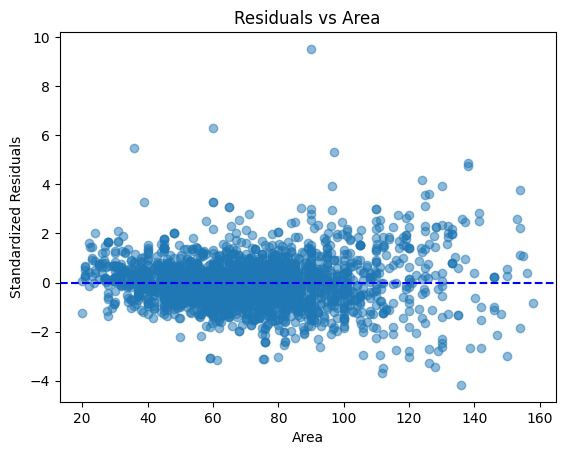

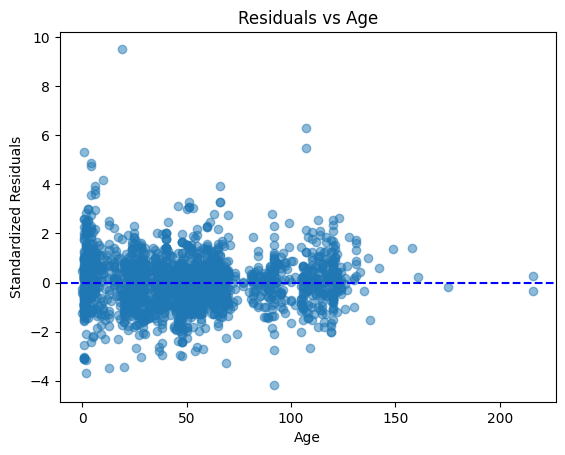

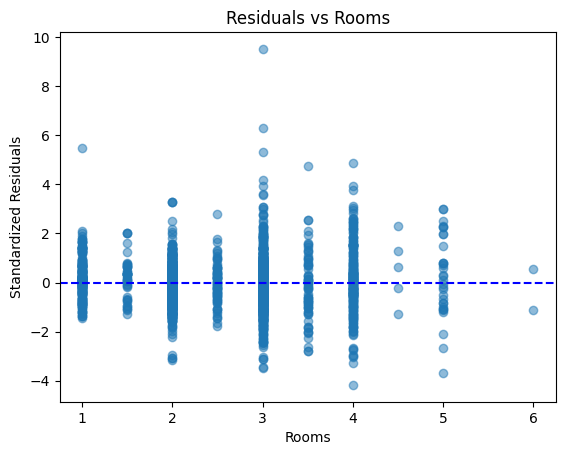

In [270]:
# Define function to plot residuals vs independent variables
def plot_residuals(x, y, xlabel):
    plt.scatter(x, y, alpha=0.5)
    plt.axhline(y=0, color='blue', linestyle='--')
    plt.xlabel(xlabel)
    plt.ylabel("Standardized Residuals")
    plt.title(f"Residuals vs {xlabel}")
    plt.show()

# Plot residuals against numerical variables
plot_residuals(data["area"], r_H04, "Area")
plot_residuals(data["age"], r_H04, "Age")
plot_residuals(data["rooms"], r_H04, "Rooms")